# Group Project 2
### Code, Draft 1: by Rishi Gummakonda
### Share Date & Time: 04/28/2021, 6:00 AM

### Objectives for the Data Analysis Portion
1. Leverage marketing response model based on regression analysis

In [1]:
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns



import sklearn
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score,mean_absolute_error,
                             mean_squared_error,explained_variance_score,r2_score,
                            confusion_matrix,precision_score, recall_score, f1_score)
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import utils

from statsmodels.graphics.regressionplots import *
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
#Organic Visit（Owned Media)
owned = pd.read_excel('/Users/rishigummakonda/Desktop/MKT 325/Travel-Data.xls', header = 1, usecols="A:E")

#Cooperative Sites (Earned Media) Table
earned = pd.read_excel('/Users/rishigummakonda/Desktop/MKT 325/Travel-Data.xls', header = 1, usecols="A,F:I")

#Search Visit (Paid Media) Table
paid = pd.read_excel('/Users/rishigummakonda/Desktop/MKT 325/Travel-Data.xls', header = 1, usecols="A,J:M")

#Internal Community Table
internal = pd.read_excel('/Users/rishigummakonda/Desktop/MKT 325/Travel-Data.xls', header = 1, usecols="A,N:Q")

#Mobile Table
mobile = pd.read_excel('/Users/rishigummakonda/Desktop/MKT 325/Travel-Data.xls', header = 1, usecols="A,R:U")

#Revenue and Advertising Tables 
#In one table for simplicity
finances = pd.read_excel('/Users/rishigummakonda/Desktop/MKT 325/Travel-Data.xls', header = 1, usecols="A,V:Z")

In [3]:
mobile.head()

,DATE,Unique Visitors.4,Unique Pageviews.4,Avg. Time on Page.4,Bounce Rate.4
0,2018-08-01,NaN,NaN,NaN,NaN
1,2018-08-02,NaN,NaN,NaN,NaN
2,2018-08-03,NaN,NaN,NaN,NaN
3,2018-08-04,NaN,NaN,NaN,NaN
4,2018-08-05,NaN,NaN,NaN,NaN


In [4]:
#Renaming columns
owned.columns = ["date", "owned_uv", "owned_pgv", "owned_avgtime", "owned_br"]
earned.columns = ["date", "earned_uv", "earned_pgv", "earned_avgtime", "earned_br"]
paid.columns = ["date", "paid_uv", "paid_pgv", "paid_avgtime", "paid_br"]
internal.columns = ["date", "internal_uv", "internal_pgv", "internal_avgtime", "internal_br"]
mobile.columns = ["date", "mobile_uv", "mobile_pgv", "mobile_avgtime", "mobile_br"]
finances.columns = ["date", "on_rev", "off_rev", "off/on", "total_rev", "total_cost"]
#Changed "Online+offline" to total_revenue, and "Investment" to total_cost for simplicity

The code below creates a visual of a correlation matrix. Shows what factors correlate to others. High correlations are anywhere from 0,50 to 1.00. Negative correlations within 0.25 to 1.0 are also interesting to note.

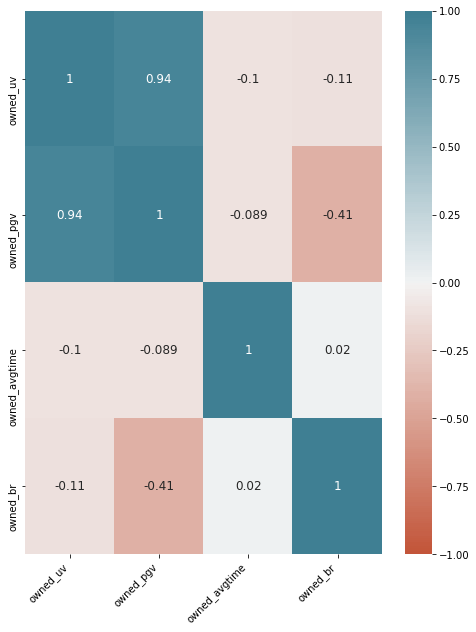

In [5]:
plt.figure(figsize=(8,10))
corr = owned.corr().round(3)
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=False,
    annot=True,
    annot_kws={"size": 12}
    
    
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize=10
);

Notable values:
<li>
    0.94 = unique page visitors and unique page views</li>
<li>
    -0.41 = bounce rate and unique page views</li>

<p> Below is the correlation matrix for finances</p>

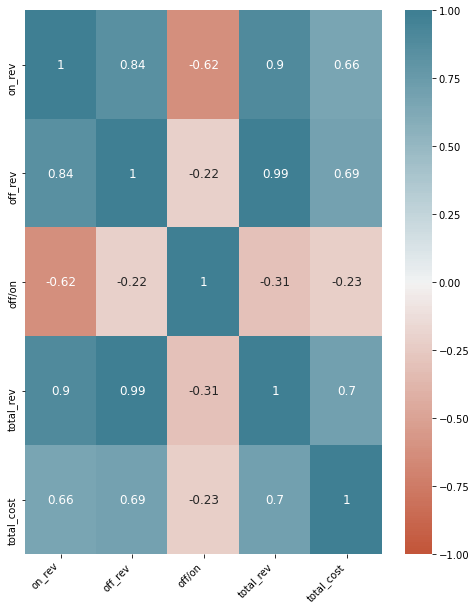

In [6]:
plt.figure(figsize=(8,10))
corr = finances.corr().round(3)
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=False,
    annot=True,
    annot_kws={"size": 12}
    
    
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize=10
);

Notable values:
<li>0.84 = on_rev to off_rev, this means they generally generate revenue at the same rate</li>
<li>=0.62 = on_rev to off/on rev, tbh not sure what this means </li>
<li> 0.9 = on_rev to total_rev</li>
<li> 0.66 = on_rev to toal cost </li>
<li> 0.99 = off_rev to total_rev </li>
<li> 0.69 = off_rev to total_cost </li>
<li> -0.31 = off/on to total rev </li>

Here I'm combining the owned and finances table so i can make a matrix that shows what owned numbers correlate with the finance numbers

In [7]:
owned_finances = pd.merge(left = owned, right=finances)
owned_finances.head()

,date,owned_uv,owned_pgv,owned_avgtime,owned_br,on_rev,off_rev,off/on,total_rev,total_cost
0,2018-08-01,241294,820096,105.457414,0.433131,6311475,60214654,9.540504,66526129,150133.52
1,2018-08-02,255647,864326,103.978332,0.417829,6138000,60016084,9.777791,66154084,148704.11
2,2018-08-03,246990,841931,102.329678,0.429202,5839334,49144515,8.416116,54983849,152222.44
3,2018-08-04,202238,675169,97.733350,0.450557,5149912,36239293,7.036876,41389205,123268.05
4,2018-08-05,183800,612308,98.577034,0.451699,5856520,49532353,8.457643,55388873,114234.61


Here I recreate a correlation matrix, only showing correlations the finance values

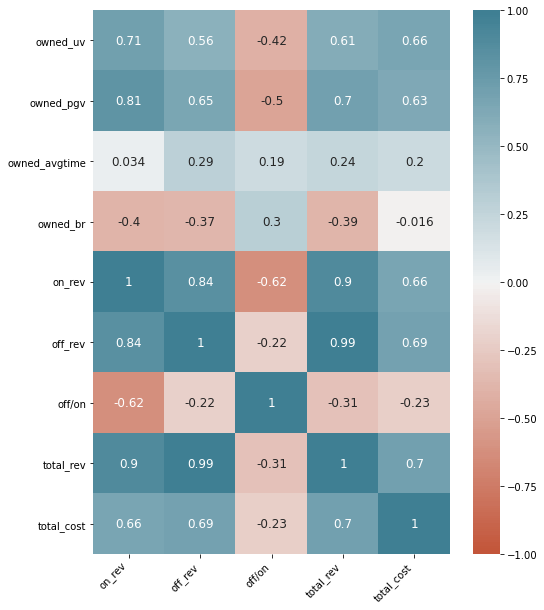

In [8]:
plt.figure(figsize=(8,10))
corr = owned_finances.corr()[["on_rev", "off_rev", "off/on", "total_rev", "total_cost"]].round(3)
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=False,
    annot=True,
    annot_kws={"size": 12}
    
    
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize=10
);

In our scenario, the idea would be to see what features most highly correlate to total_rev. But other values are interesting to note as well.

Notable values:
<li> 0.71 = owned unique visitors to on_rev </li>
<li> 0.56 = owned unique visitors to off_rev </li>
<li> -0.42 = owned unique visitors to off/on </li>
<li> 0.61 = owned unique visitors to total_rev </li>
<li> 0.66 = owned unique visitors to total_cost </li>

...and so on



Here I'm recreating the giant table to make a giant correlation matrix.

In [9]:
t1 = pd.merge(owned,earned)
t2 = pd.merge(t1,paid)
t3= pd.merge(t2,internal)
t4 = pd.merge(t3,mobile)
bigtable = pd.merge(t4,finances)
bigtable.head()

,date,owned_uv,owned_pgv,owned_avgtime,owned_br,earned_uv,earned_pgv,earned_avgtime,earned_br,paid_uv,...,internal_br,mobile_uv,mobile_pgv,mobile_avgtime,mobile_br,on_rev,off_rev,off/on,total_rev,total_cost
0,2018-08-01,241294,820096,105.457414,0.433131,91338,235523,96.776953,0.547922,37177,...,0.243494,NaN,NaN,NaN,NaN,6311475,60214654,9.540504,66526129,150133.52
1,2018-08-02,255647,864326,103.978332,0.417829,98491,249249,94.918732,0.538760,36357,...,0.243802,NaN,NaN,NaN,NaN,6138000,60016084,9.777791,66154084,148704.11
2,2018-08-03,246990,841931,102.329678,0.429202,96275,245907,95.629137,0.541837,28480,...,0.233513,NaN,NaN,NaN,NaN,5839334,49144515,8.416116,54983849,152222.44
3,2018-08-04,202238,675169,97.733350,0.450557,79131,201669,90.698461,0.535145,22377,...,0.288106,NaN,NaN,NaN,NaN,5149912,36239293,7.036876,41389205,123268.05
4,2018-08-05,183800,612308,98.577034,0.451699,71025,183932,90.358881,0.546901,20816,...,0.267794,NaN,NaN,NaN,NaN,5856520,49532353,8.457643,55388873,114234.61


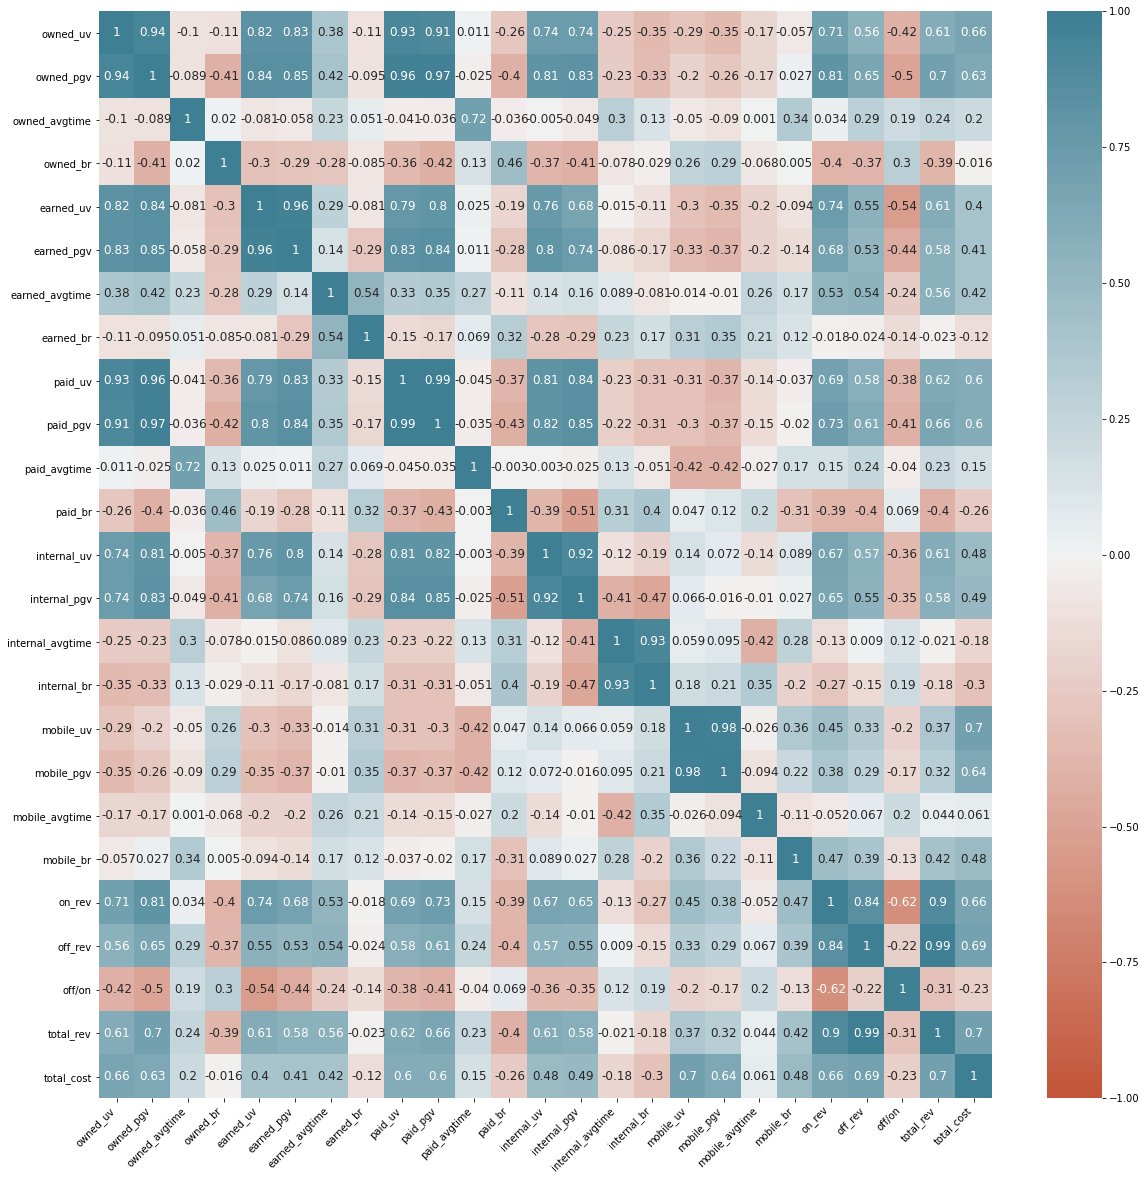

In [10]:
plt.figure(figsize=(20,20))
corr = bigtable.corr().round(3)
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=False,
    annot=True,
    annot_kws={"size": 12}
    
    
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize=10
);

In [11]:
#listing the correlation values
correlation_mat = bigtable.corr()

corr_pairs = correlation_mat.unstack()

print(corr_pairs)

owned_uv    owned_uv         1.000000
            owned_pgv        0.942317
            owned_avgtime   -0.100683
            owned_br        -0.111226
            earned_uv        0.820643
                               ...   
total_cost  on_rev           0.658407
            off_rev          0.687911
            off/on          -0.224819
            total_rev        0.700448
            total_cost       1.000000
Length: 625, dtype: float64


In [12]:
#sorting
sorted_pairs = corr_pairs.sort_values(kind="quicksort")

print(sorted_pairs)

off/on      on_rev         -0.620056
on_rev      off/on         -0.620056
earned_uv   off/on         -0.538413
off/on      earned_uv      -0.538413
paid_br     internal_pgv   -0.512197
                              ...   
mobile_br   mobile_br       1.000000
on_rev      on_rev          1.000000
off_rev     off_rev         1.000000
paid_br     paid_br         1.000000
total_cost  total_cost      1.000000
Length: 625, dtype: float64


In [13]:
strong_pairs = sorted_pairs[abs(sorted_pairs) > 0.5]
strong_pairs_no1 = strong_pairs[abs(sorted_pairs) < 1]

print(strong_pairs_no1)

off/on      on_rev         -0.620056
on_rev      off/on         -0.620056
earned_uv   off/on         -0.538413
off/on      earned_uv      -0.538413
paid_br     internal_pgv   -0.512197
                              ...   
mobile_pgv  mobile_uv       0.976077
off_rev     total_rev       0.993094
total_rev   off_rev         0.993094
paid_uv     paid_pgv        0.993824
paid_pgv    paid_uv         0.993824
Length: 148, dtype: float64


Usually 0.5 and above can be considered strong correlation for most datasets, but this one has a lot of those (74 feature pairs). So I'll change it to 0.8

In [34]:
strong_pairs = sorted_pairs[abs(sorted_pairs) > 0.8]
strong_pairs_no1 = strong_pairs[abs(sorted_pairs) < 1]
print(len(strong_pairs_no1))
print(strong_pairs_no1)

54
paid_pgv          earned_uv           0.801331
earned_uv         paid_pgv            0.801331
internal_uv       owned_pgv           0.806784
owned_pgv         internal_uv         0.806784
                  on_rev              0.806847
on_rev            owned_pgv           0.806847
internal_uv       paid_uv             0.811911
paid_uv           internal_uv         0.811911
internal_uv       paid_pgv            0.817564
paid_pgv          internal_uv         0.817564
owned_uv          earned_uv           0.820643
earned_uv         owned_uv            0.820643
earned_pgv        owned_uv            0.827995
owned_uv          earned_pgv          0.827995
internal_pgv      owned_pgv           0.828127
owned_pgv         internal_pgv        0.828127
earned_pgv        paid_uv             0.830442
paid_uv           earned_pgv          0.830442
on_rev            off_rev             0.840211
off_rev           on_rev              0.840211
paid_pgv          earned_pgv          0.840389
earned_pgv

Initial data analysis shows that making that giant table was ultimately fruitless. Most of the above 0.80 correlations are either completely obvious, or completely conicidentally related. That's at first glance. For example, the number of unique page views generated by paid strategy has a 0.801 correlation to unique visitors generated through the earned strategy. I think thats completely random. i don't see a real life reason as to why that would make sense. 

In [37]:
#only looking at pairs that go with total revenue
strong_pairs = sorted_pairs[abs(sorted_pairs) > 0.5][['total_rev']]
strong_pairs_no1 = strong_pairs[abs(sorted_pairs) < 1]

print(len(strong_pairs_no1))
print(strong_pairs_no1)


12
total_rev  earned_avgtime    0.554884
           earned_pgv        0.576309
           internal_pgv      0.583150
           earned_uv         0.607240
           internal_uv       0.607842
           owned_uv          0.608770
           paid_uv           0.623128
           paid_pgv          0.656277
           total_cost        0.700448
           owned_pgv         0.701340
           on_rev            0.897973
           off_rev           0.993094
dtype: float64


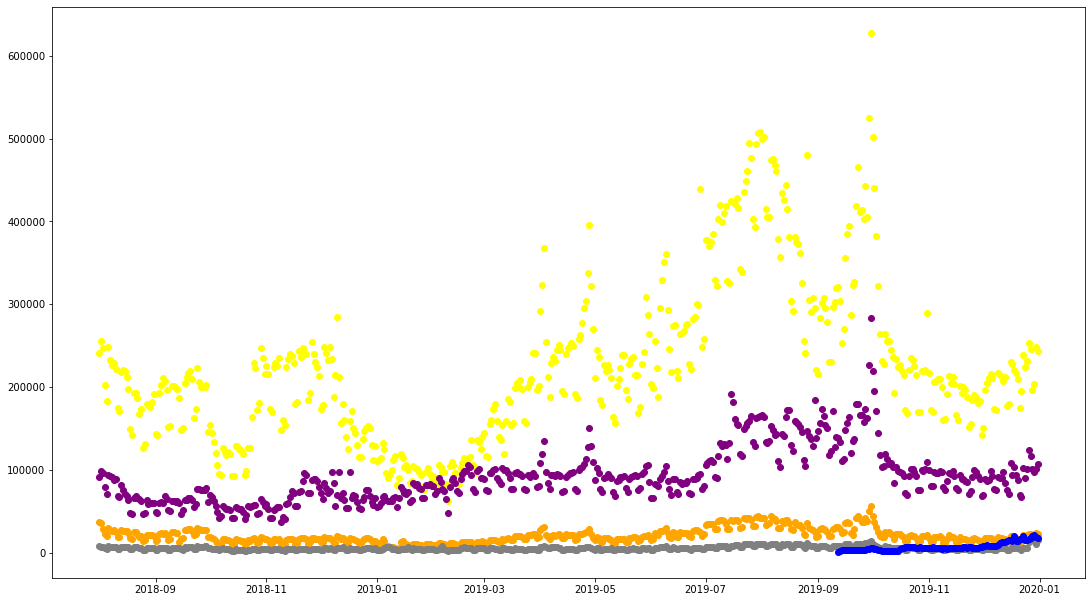

In [29]:
#Unique Visitors Cart
plt.scatter(x=owned['date'], y=owned['owned_uv'], color='yellow')
plt.scatter(x=owned['date'], y=earned['earned_uv'], color = 'purple')
plt.scatter(x=owned['date'], y=paid['paid_uv'], color = 'orange')
plt.scatter(x=owned['date'], y=internal['internal_uv'], color = 'grey')
plt.scatter(x=owned['date'], y=mobile['mobile_uv'], color = 'blue')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.show()

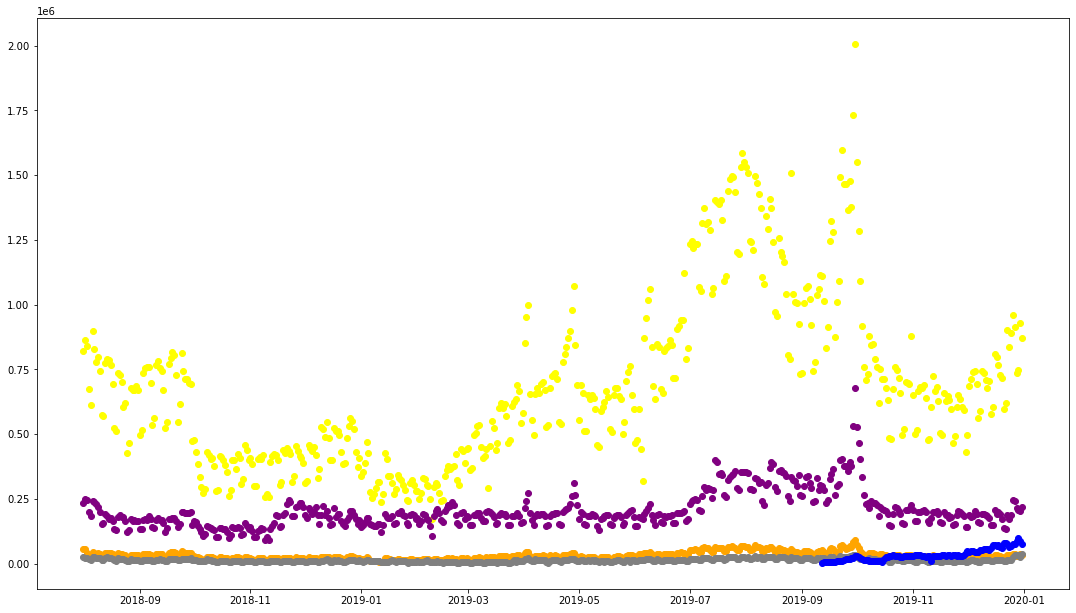

In [32]:
#Unique Page Views Cart
plt.scatter(x=owned['date'], y=owned['owned_pgv'], color='yellow')
plt.scatter(x=owned['date'], y=earned['earned_pgv'], color = 'purple')
plt.scatter(x=owned['date'], y=paid['paid_pgv'], color = 'orange')
plt.scatter(x=owned['date'], y=internal['internal_pgv'], color = 'grey')
plt.scatter(x=owned['date'], y=mobile['mobile_pgv'], color = 'blue')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.show()

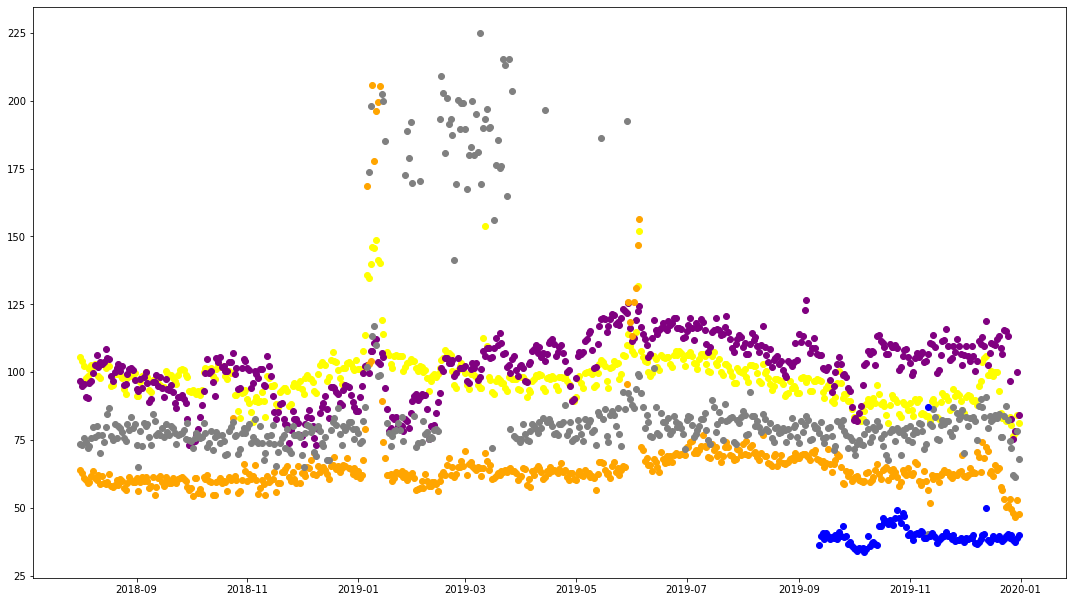

In [33]:
#Avg Time Spent Chart
plt.scatter(x=owned['date'], y=owned['owned_avgtime'], color='yellow')
plt.scatter(x=owned['date'], y=earned['earned_avgtime'], color = 'purple')
plt.scatter(x=owned['date'], y=paid['paid_avgtime'], color = 'orange')
plt.scatter(x=owned['date'], y=internal['internal_avgtime'], color = 'grey')
plt.scatter(x=owned['date'], y=mobile['mobile_avgtime'], color = 'blue')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.show()

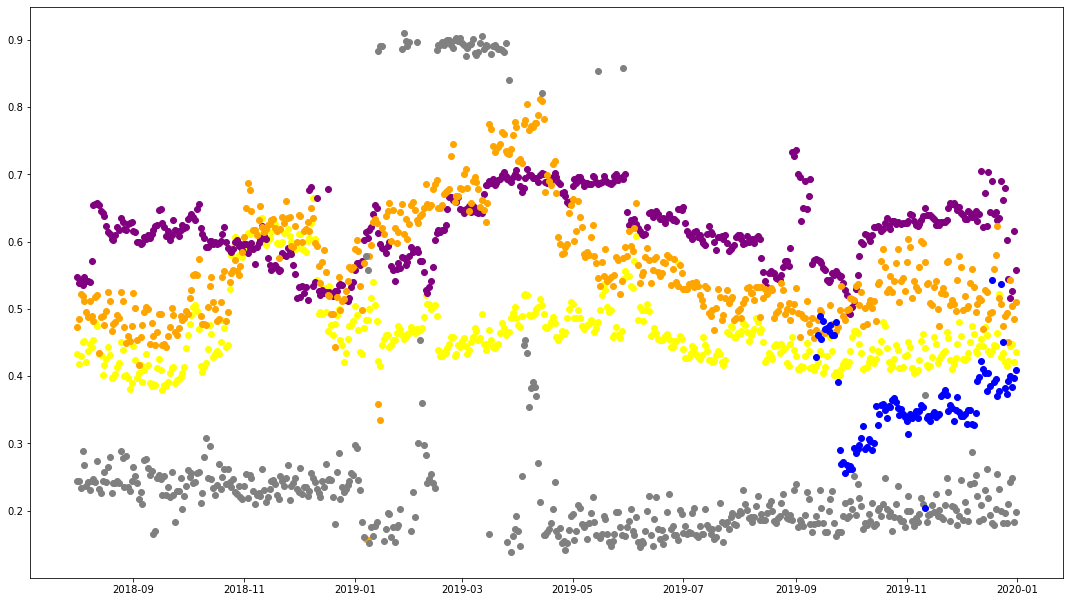

In [18]:
#bounce rate graph
plt.scatter(x=owned['date'], y=owned['owned_br'], color='yellow')
plt.scatter(x=owned['date'], y=earned['earned_br'], color = 'purple')
plt.scatter(x=owned['date'], y=paid['paid_br'], color = 'orange')
plt.scatter(x=owned['date'], y=internal['internal_br'], color = 'grey')
plt.scatter(x=owned['date'], y=mobile['mobile_br'], color = 'blue')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.show()

## Rishi's To Do List
1. Finish Data Cleaning
1. Resize graphs
1. Fix Regression Code Below
1. Model for each media type (5).
1. Regression Graphs
1. Basic Analysis to set up Izzy, Dylan and Jake's answer to the second question

Here I'm gonna run a linear regression of the big table. In the next draft of the code, when we know what features have the most correlation, we can change what we include in the regression model. 

In [19]:
df=bigtable
df.fillna(0, inplace=True)
del df['date']
df.head()

,owned_uv,owned_pgv,owned_avgtime,owned_br,earned_uv,earned_pgv,earned_avgtime,earned_br,paid_uv,paid_pgv,...,internal_br,mobile_uv,mobile_pgv,mobile_avgtime,mobile_br,on_rev,off_rev,off/on,total_rev,total_cost
0,241294,820096,105.457414,0.433131,91338,235523,96.776953,0.547922,37177,57293,...,0.243494,0.0,0.0,0.0,0.0,6311475,60214654,9.540504,66526129,150133.52
1,255647,864326,103.978332,0.417829,98491,249249,94.918732,0.538760,36357,55463,...,0.243802,0.0,0.0,0.0,0.0,6138000,60016084,9.777791,66154084,148704.11
2,246990,841931,102.329678,0.429202,96275,245907,95.629137,0.541837,28480,42816,...,0.233513,0.0,0.0,0.0,0.0,5839334,49144515,8.416116,54983849,152222.44
3,202238,675169,97.733350,0.450557,79131,201669,90.698461,0.535145,22377,33857,...,0.288106,0.0,0.0,0.0,0.0,5149912,36239293,7.036876,41389205,123268.05
4,183800,612308,98.577034,0.451699,71025,183932,90.358881,0.546901,20816,31889,...,0.267794,0.0,0.0,0.0,0.0,5856520,49532353,8.457643,55388873,114234.61


In [21]:
#m = ols('total_rev ~.',df).fit()
#print(m.summary())

In [22]:
# #ignore this I have to fix this function
# class LinearRegressionModel(object):
#     def __init__(self, x, y):
#         self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(x, y, test_size = .3, random_state=42)
#     def get_model(self):
#         return LinearRegression(fit_intercept=False)
#     def get_pred(self):
#         model = self.get_model()
#         model.fit(self.X_train,self.y_train)
#         predictions = model.predict(self.X_test)
#         return predictions
#     def print_metrics(self):
#         actual = list(self.y_test)
#         predicted = list(self.get_pred())
#         print('MAE:', mean_absolute_error(actual, predicted))
#         print('MSE:', mean_squared_error(actual, predicted))
#         print('Explained Variance Score:', explained_variance_score(actual, predicted))
#         print('R2 Score:', r2_score(actual, predicted))

In [23]:
# #Ignore this
# ## replace NaNs with 0
# bigtable.fillna(0, inplace=True)
# big_y = bigtable['total_rev']
# big_x = bigtable.drop(['total_rev'],axis=1)


In [24]:
# #Ignore this
# big_linreg = LinearRegressionModel(big_x,big_y)
# print(big_linreg)

In [25]:
# Ignore this
# big_linreg.print_metrics()